In [11]:
#import all required strings
from PreProcessor import PreProcessor
from Encoder import Encoder

# PreProcessor Demo Script
The following script demos the capabilities of the pre-processor and some preliminary analysis that we performed on the dataset itself

## Initializing the PreProcessor

### Create an instance of the PreProcessor class and import the dataset from a file

The preprocessor imports files based on the file name. The file must be located in the "datasets" folder. We automatically replace Null and NaN dataset entries with "N/A"

In [12]:
train_file_name = "train.tsv"
labels = [
        'id',                # Column 1: the ID of the statement ([ID].json).
        'label',             # Column 2: the label.
        'statement',         # Column 3: the statement.
        'subjects',          # Column 4: the subject(s).
        'speaker',           # Column 5: the speaker.
        'speaker_job_title', # Column 6: the speaker's job title.
        'state_info',        # Column 7: the state info.
        'party_affiliation', # Column 8: the party affiliation.
        
        # Column 9-13: the total credit history count, including the current statement.
        'count_1', # barely true counts.
        'count_2', # false counts.
        'count_3', # half true counts.
        'count_4', # mostly true counts.
        'count_5', # pants on fire counts.
        
        'context' # Column 14: the context (venue / location of the speech or statement).
    ]

#initialize the PreProcessor
pre_processor = PreProcessor(verbose=True)
pre_processor.import_data_from_file(
    file_name="train.tsv",
    deliminator='\t',
    headers = labels,
    replace_Null_NaN=True)


PreProcessor.__init()__: Data Imported


### Denoting which column in the dataset corresponds to the labels for each data sample

We provide a custom encoding (optional) so that each possible label can be encoded using a unique number. For additional flexibility, the labels (or any set of data for that matter) can be encoded based on the following options:
- Standard mapping: Labels are encoded either through the provided encoding_mapping or automatically using a unique integer for each label
- normalized mapping: When it makes sense, labels can be normalized so as to range from 0 to 1
- binarized mapping: Finally, labels can be binarized to be either 0 or 1. This generally only makes sense with only two labels or if data is specifically constructed to be binarized (ex: mostly true vs mostly false)

In [13]:

#set the label column
label_mapping = {'pants-fire':0,
             'false':1,
             'barely-true':2,
             'half-true':3,
             'mostly-true':4,
             'true':5}
pre_processor.set_label_header(
    label_header='label',
    encoding_mapping=label_mapping,
    normalize=False,
    binarize=False
)

Encoder.encode: encoding_mappings: {'pants-fire': 0, 'false': 1, 'barely-true': 2, 'half-true': 3, 'mostly-true': 4, 'true': 5}



## Analyzing the data
This secion is broken down into the following tasks:
1. Types of encoders
2. Accessing a specific column in the data
3. Apply filters to the data to filter for specific features or specific labels
4. Generate a plot for the data
5. Obtain encoded data using either a raw encoding or bag-of-words

### Types of encoders:

There are three types of encoders:
1. Standard encoder: this is the same encoder that is used to encode the labels, and it includes the same parameters (custom mapping, binarization, normalization)
2. Bag-of-words: This encoder performs a bag-of-words encoding. It includes options to clean strings (clean up punctuation, ect), remove stop words (remove common words), and lematize (reduce words down to their simplest forms).
3. Credit score encoder: This encoder computes a weighted average and uses the weighted average of the given columns as the encoding (ex: for a credit history score).

### Access a specific column in the data
For this example, we evaluate the subject for each sample. In this case, we desire a bag-of-words encoder. 

Below, we feature an example of both encoders

In [14]:
#standard encoding example
party_encoder = pre_processor.get_standard_encoder_for_features(
    feature_name="party_affiliation",
    encoding_mapping=None,
    normalize=False,
    Binarize=False
)

#bag of words example
subjects_encoder = pre_processor.get_bag_of_words_encoder_for_feature(
    feature_name="subjects",
    clean_strings=True,
    remove_stop_words=True,
    lematize=True
)

#get all of the possible subjects that we could access
unique_subjects = subjects_encoder.feature_names

#Weighted Average Encoder Example
credit_score_encoder = pre_processor.get_credit_history_encoder_for_features(
    feature_names= ['count_1','count_2','count_3','count_4','count_5']
)

Encoder.encode: encoding_mappings: {'republican': 1, 'activist': 2, 'education-official': 3, 'democratic-farmer-labor': 4, 'independent': 5, 'labor-leader': 6, 'business-leader': 7, 'journalist': 8, 'none': 9, 'constitution-party': 10, 'libertarian': 11, 'newsmaker': 12, 'government-body': 13, 'green': 14, 'talk-show-host': 15, 'ocean-state-tea-party-action': 16, 'N/A': 17, 'liberal-party-canada': 18, 'Moderate': 19, 'state-official': 20, 'tea-party-member': 21, 'democrat': 22, 'columnist': 23, 'organization': 24}



/home/david/anaconda3/envs/STA561/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/david/Documents/sta561project/preprocess/Encoder.py:326: RuntimeWarning: invalid value encountered in divide
  weighted_credit_counts = credit_counts / sums[:,None]


### Applying Filters
There were over 180 different subjects found. Say that it is desired to see what the top 10 subjects were for posts that were labeled as either "false" or "pants-fire". This can be accomplished as follows

Note: There is an option to return the most popular features either by raw count or by the percentage that a give feature corresponds to a specific label or set of labels


In [15]:
#as a raw count
pre_processor.get_most_popular_features(
    encoder=party_encoder,
    max_terms=3,
    label_filters=["true"],
    percentage=False
)

(['republican', 'democrat', 'none'], array([660., 658., 246.]))

In [16]:
#as a percentage
pre_processor.get_most_popular_features(
    encoder=party_encoder,
    max_terms=3,
    label_filters=["true"],
    percentage=True
)

(['business-leader', 'green', 'columnist'],
 array([0.55555556, 0.33333333, 0.31428571]))

In [17]:
most_popular_terms,counts = pre_processor.get_most_popular_features(
    encoder=subjects_encoder,
    max_terms=10,
    label_filters=['false','pants-fire'],
    percentage=True
)

#filter for these terms
subjects_encoder.configure_filter(most_popular_terms)

/home/david/anaconda3/envs/STA561/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Generating Plots

There are several main plotting functions; each is described below:
1. plot_most_popular_features: this function will generate a subplot for a specific set of labels with the count of the most popular features for that label
2. plot_count_for_features: this function generates a plot for specific features. For each feature, a line plot is generated with that feature's count for each label


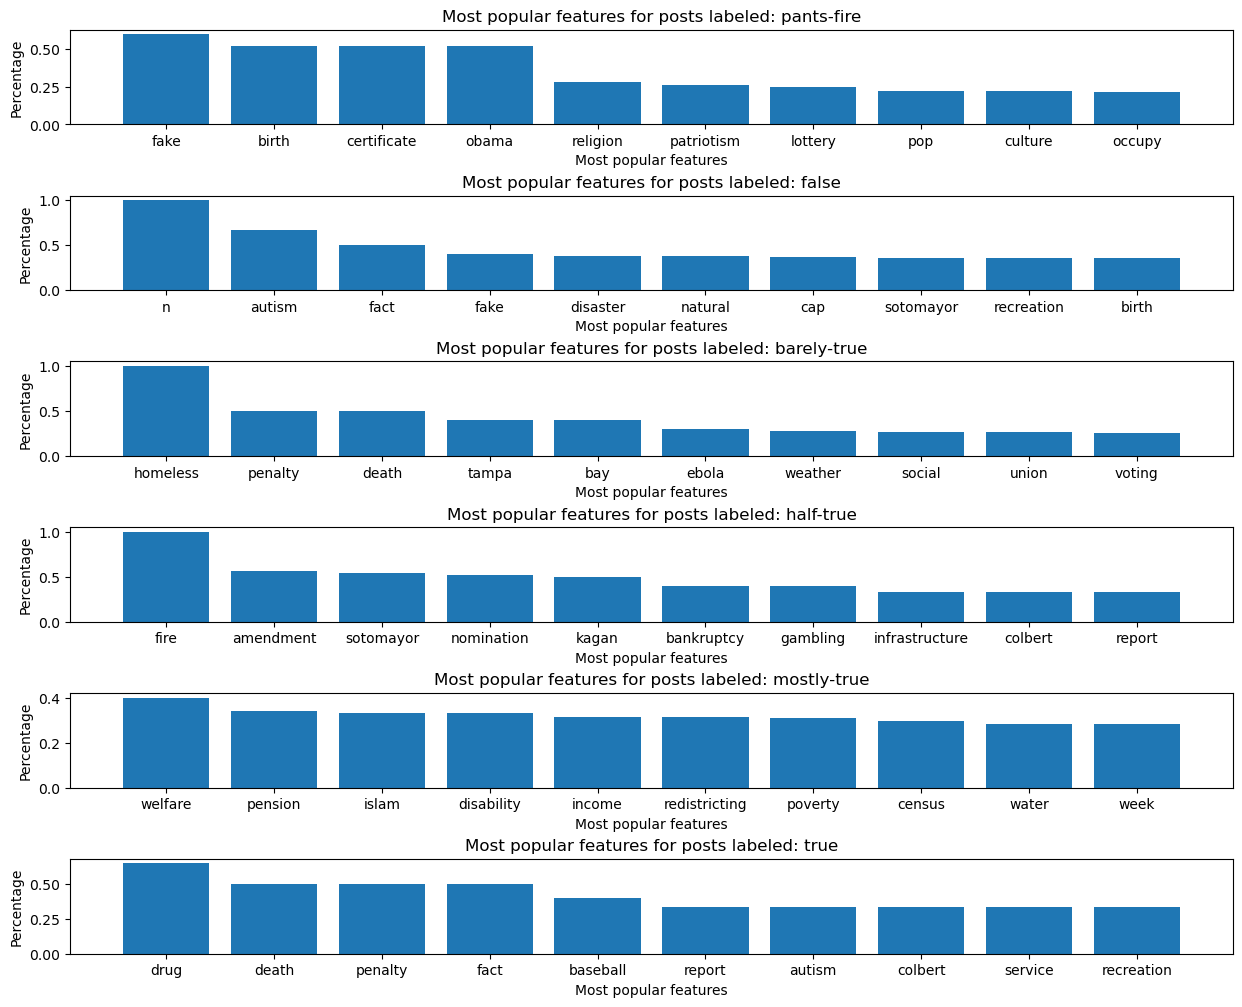

In [18]:
pre_processor.plot_most_popular_features(
    encoder=subjects_encoder,
    labels_to_plot=None,
    max_terms=10,
    percentage=True
)

['republican', 'democrat', 'none']


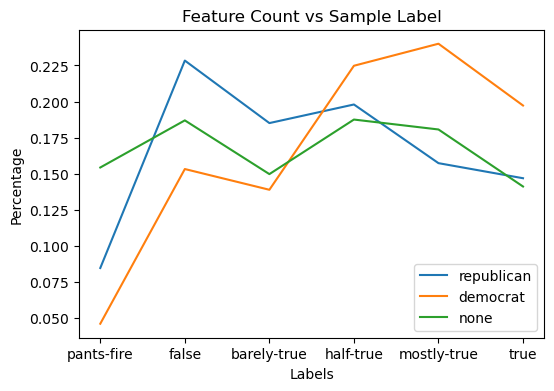

In [19]:
#get the most popular subjects
most_popular_parties,counts = pre_processor.get_most_popular_features(
    encoder=party_encoder,
    max_terms=3,
    label_filters=None,
    percentage=False)

print(most_popular_parties)

pre_processor.plot_count_for_features(
    encoder=party_encoder,
    features_to_plot=most_popular_parties,
    labels_to_plot=None,
    percentage=True
)

## Apendix:

Below are extra plots generated for most of the features to help in understanding the dataset

### Speaker

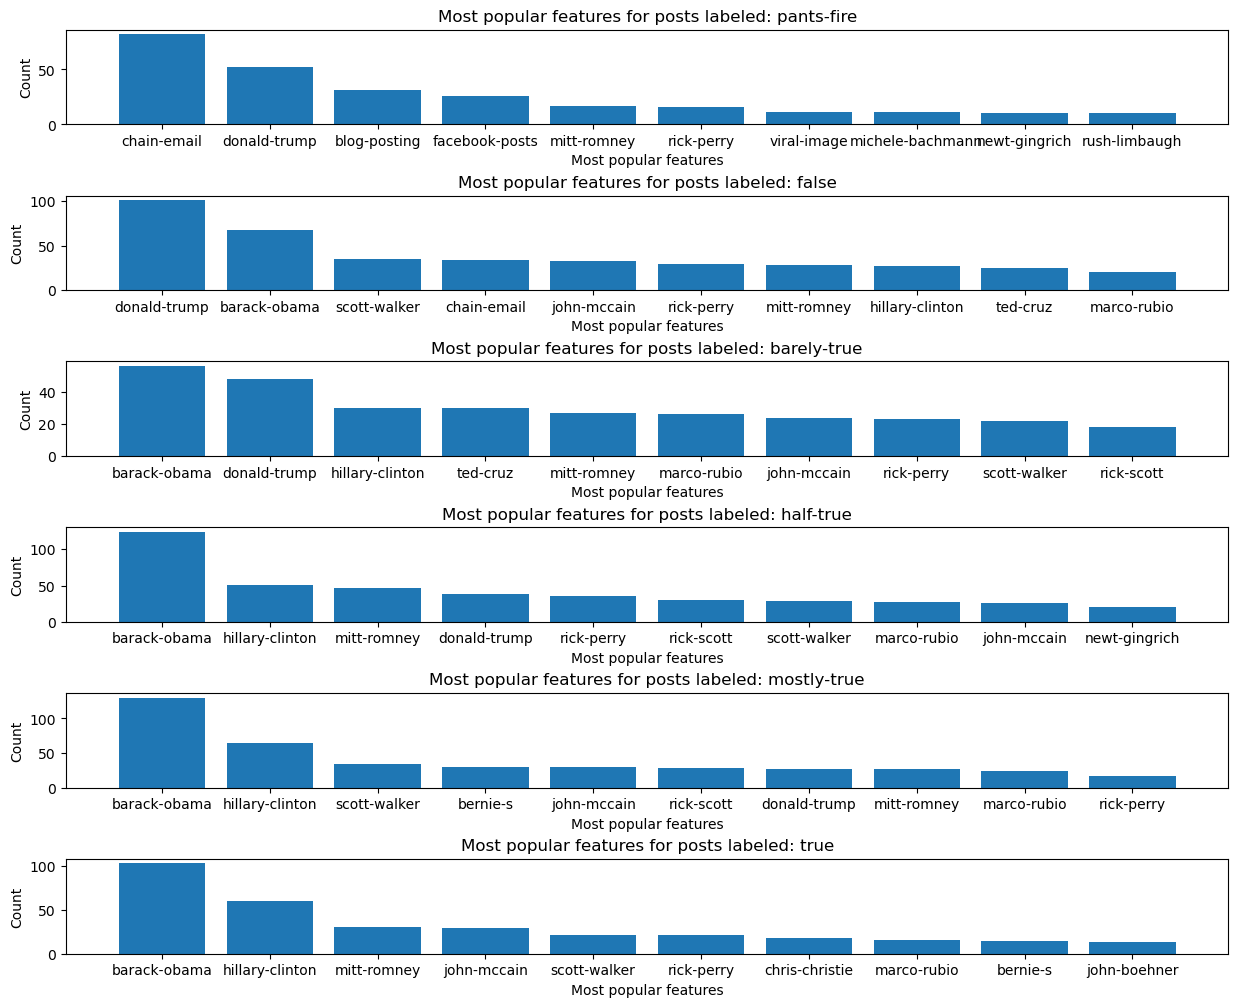

In [20]:
pre_processor.verbose = False
speaker_encoder = pre_processor.get_standard_encoder_for_features(
    feature_name='speaker',
    encoding_mapping=None,
    normalize=False,
    Binarize=False
)

pre_processor.plot_most_popular_features(
    encoder=speaker_encoder,
    labels_to_plot=None,
    max_terms=10,
    percentage=False
)

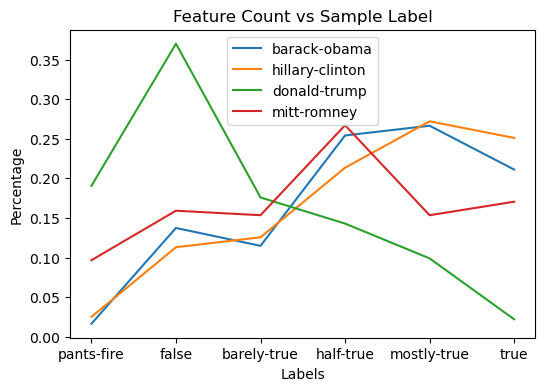

In [21]:
pre_processor.plot_count_for_features(
    encoder=speaker_encoder,
    features_to_plot=["barack-obama","hillary-clinton","donald-trump","mitt-romney"],
    percentage=True
)

### Speaker Job Title

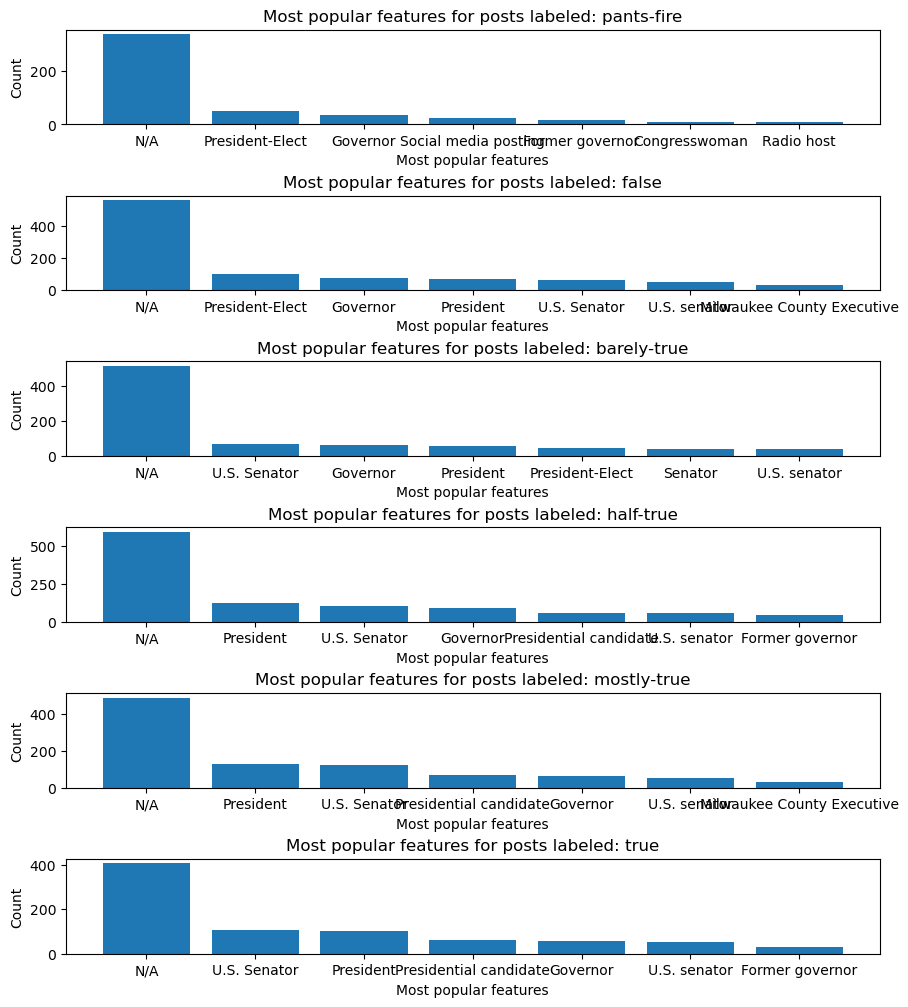

In [22]:
pre_processor.verbose = False
job_encoder = pre_processor.get_standard_encoder_for_features(
    feature_name='speaker_job_title',
    encoding_mapping=None,
    normalize=False,
    Binarize=False
)

pre_processor.plot_most_popular_features(
    encoder=job_encoder,
    labels_to_plot=None,
    max_terms=7,
    percentage=False
)

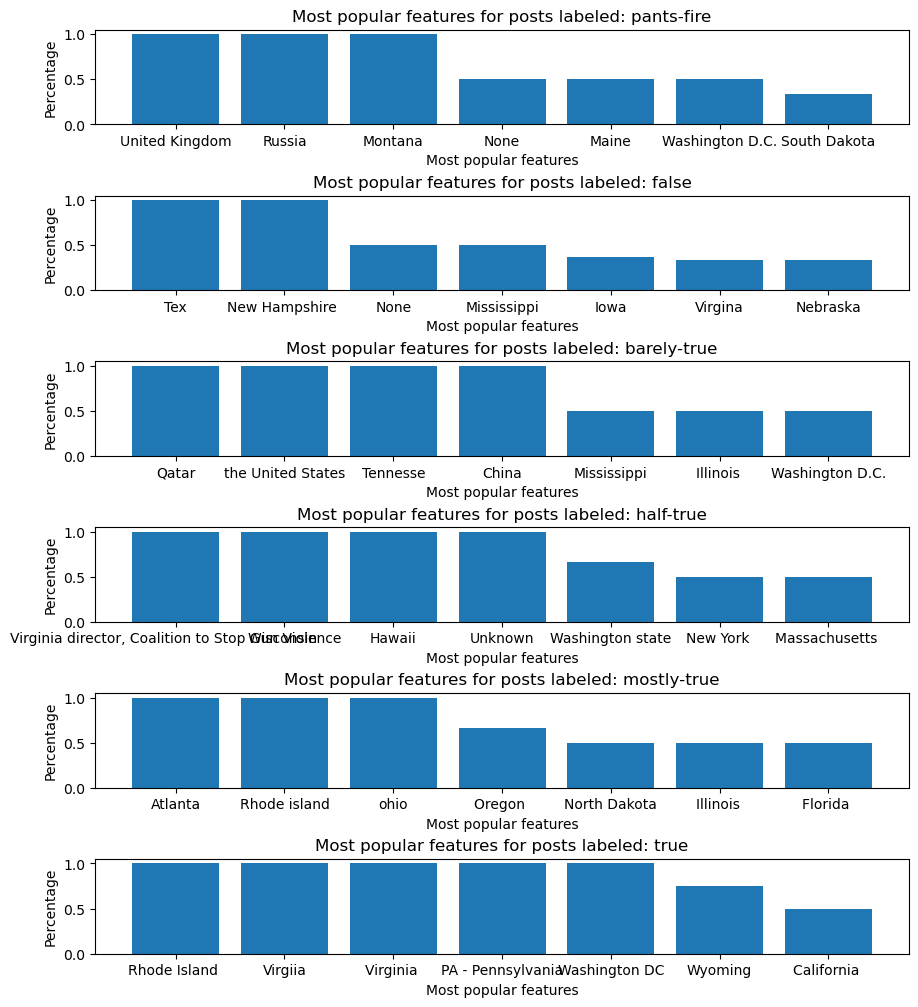

In [23]:
pre_processor.verbose = False
state_encoder = pre_processor.get_standard_encoder_for_features(
    feature_name='state_info',
    encoding_mapping=None,
    normalize=False,
    Binarize=False
)

pre_processor.plot_most_popular_features(
    encoder=state_encoder,
    labels_to_plot=None,
    max_terms=7,
    percentage=True
)

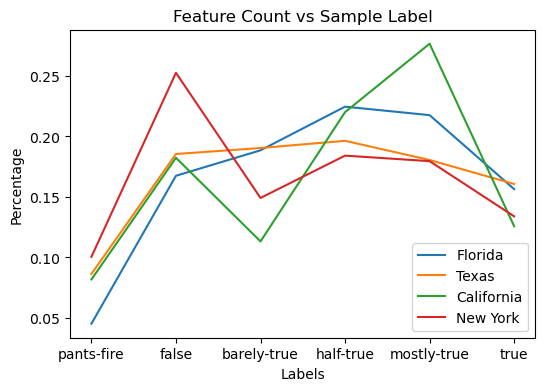

In [24]:
pre_processor.plot_count_for_features(
    encoder=state_encoder,
    features_to_plot=["Florida","Texas","California","New York"],
    percentage=True
)

### Statement

/home/david/anaconda3/envs/STA561/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


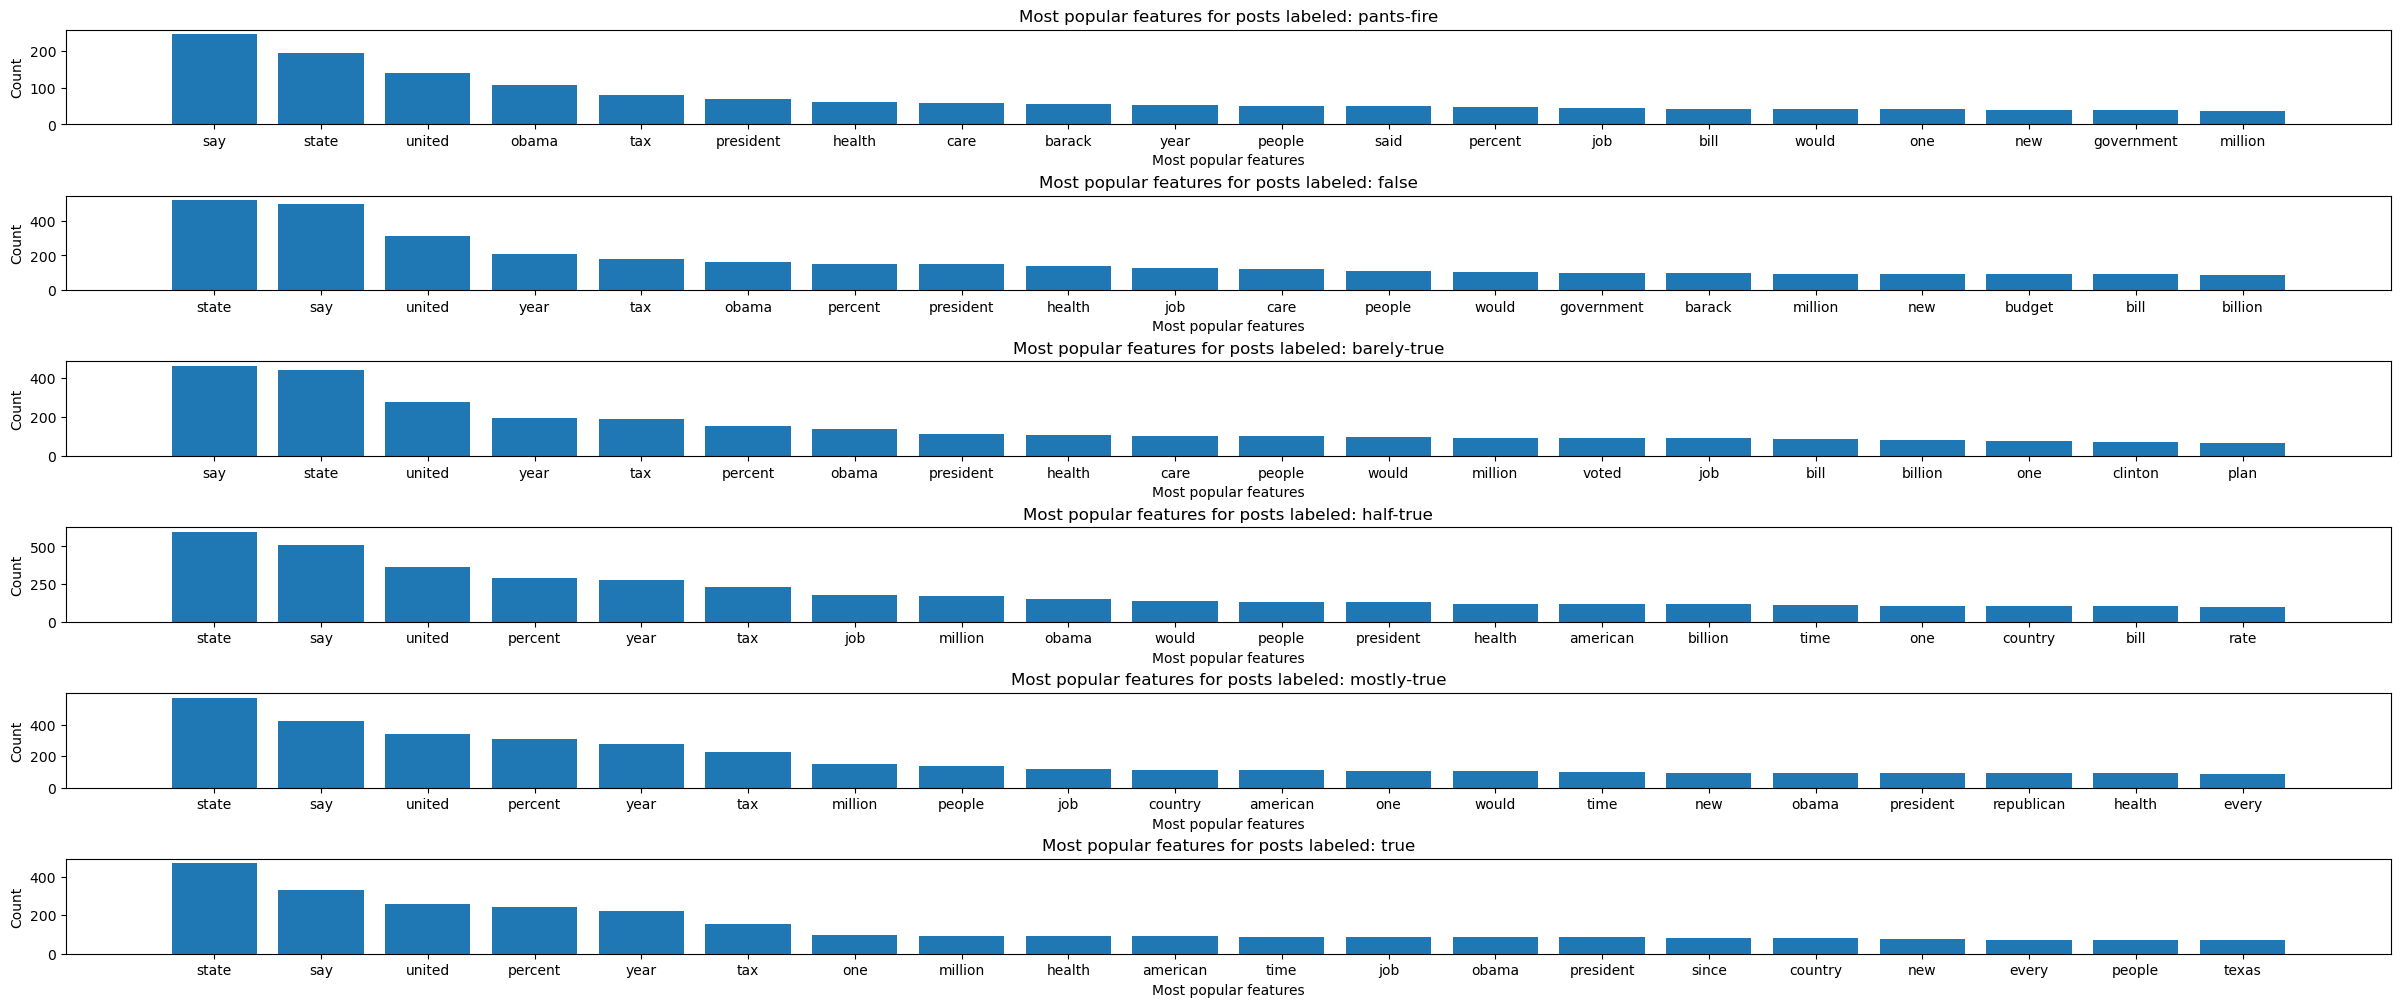

In [25]:
statement_encoder = pre_processor.get_bag_of_words_encoder_for_feature(
    feature_name="statement",
    clean_strings=True,
    remove_stop_words=True,
    lematize=True
)

pre_processor.plot_most_popular_features(
    encoder=statement_encoder,
    labels_to_plot=None,
    max_terms=20
)

### Context

/home/david/anaconda3/envs/STA561/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


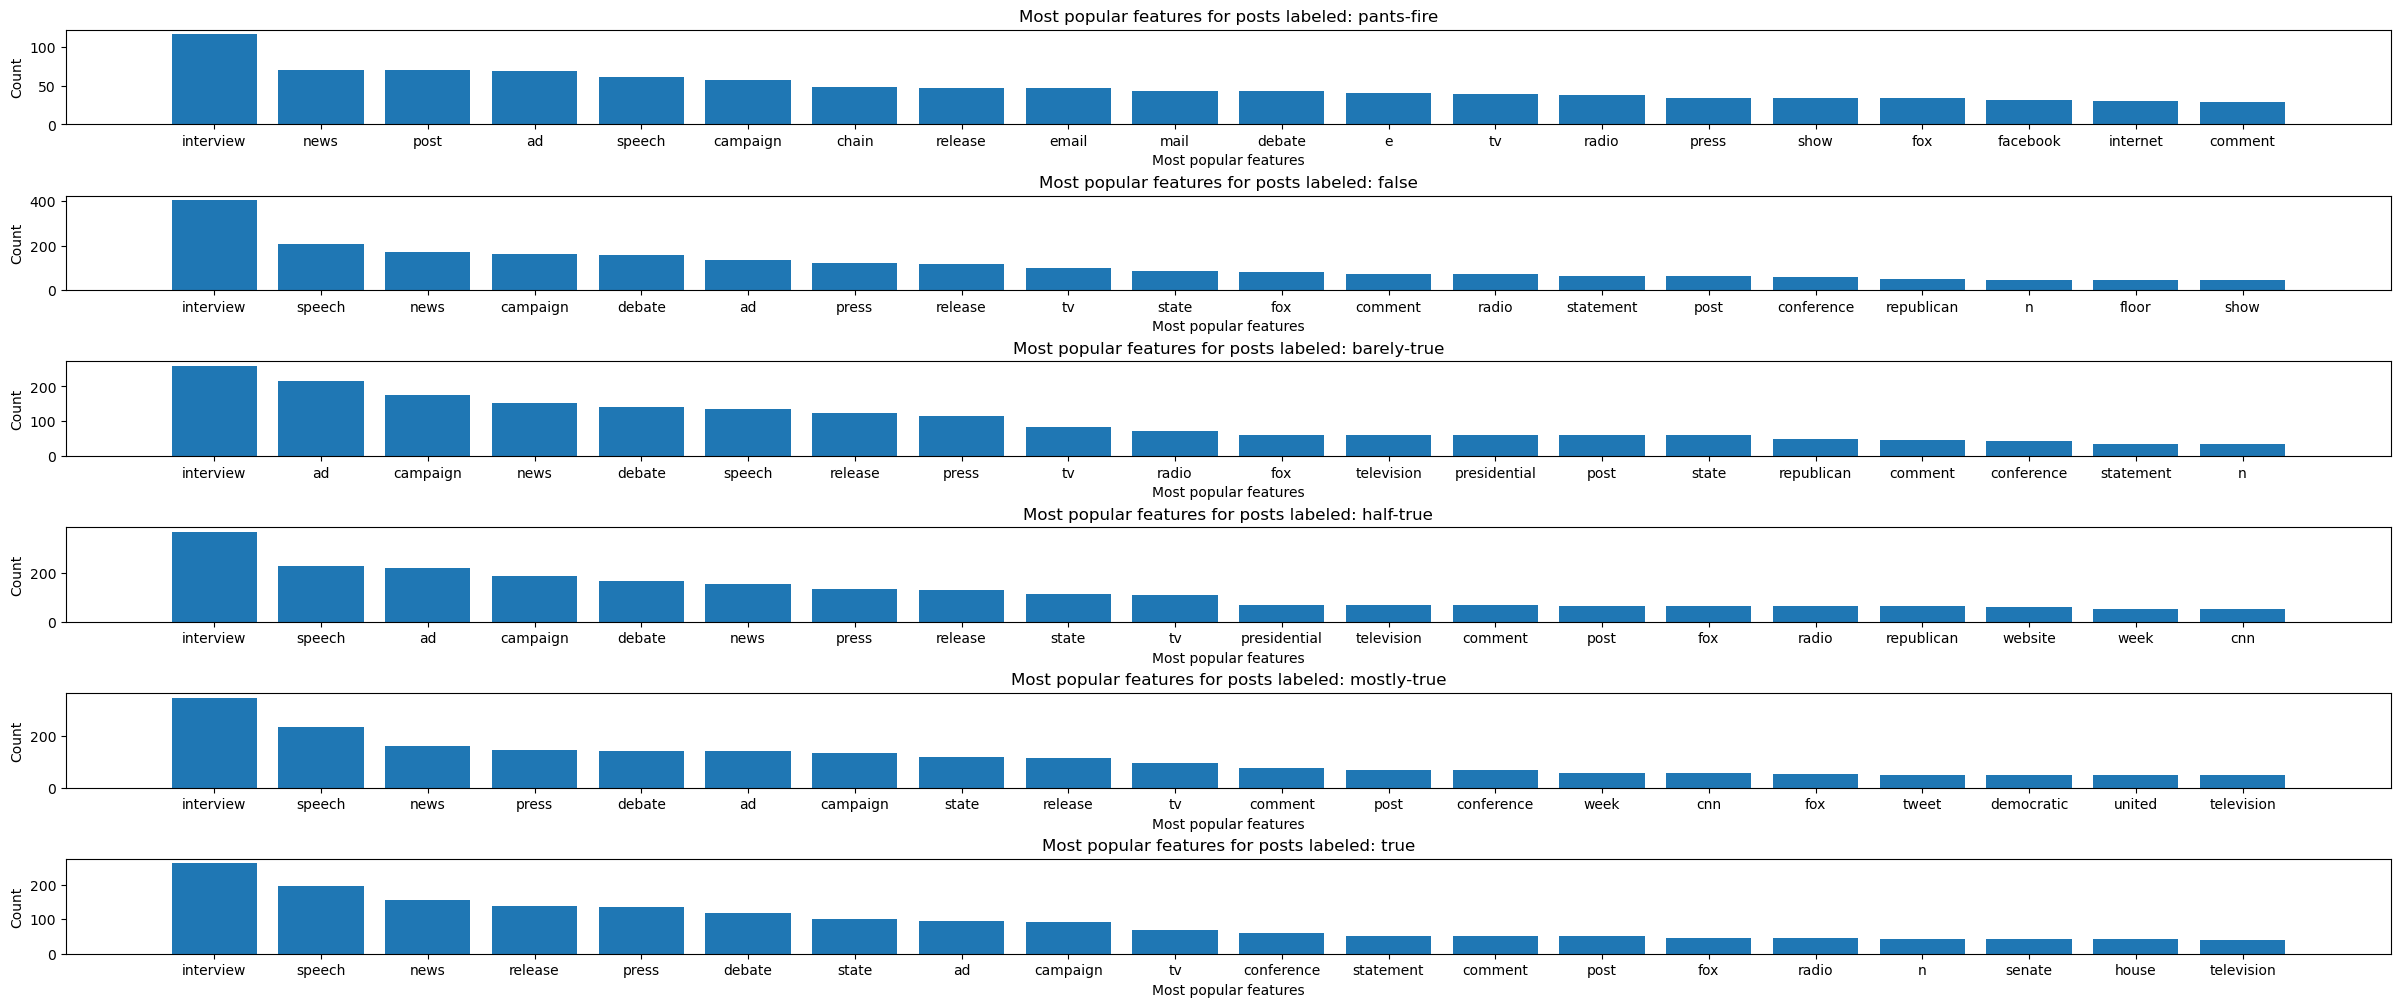

In [26]:
context_encoder = pre_processor.get_bag_of_words_encoder_for_feature(
    feature_name="context",
    clean_strings=True,
    remove_stop_words=True,
    lematize=True
)

pre_processor.plot_most_popular_features(
    encoder=context_encoder,
    labels_to_plot=None,
    max_terms=20,
    percentage=False
)